In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metadata_df = pd.read_csv('/content/metadata.csv', index_col=0)
vst_df = pd.read_csv('/content/drive/MyDrive/Ageing/vst_normalized_counts.csv', index_col=0)

In [ ]:
module_df = pd.read_csv("/content/genes_by_module (1).csv", index_col=0)

In [ ]:
genes = pd.read_csv("/content/drive/MyDrive/Ageing/All_genes.csv", index_col=0)
module_df_mice = pd.merge(module_df, genes, left_index=True, right_index=True, how='inner')
module_df = module_df_mice

In [ ]:
skin_samples = metadata_df[metadata_df['Tissue'] == 'Skin'].index
vst_skin_df = vst_df[skin_samples]
metadata_skin_df = metadata_df.loc[skin_samples]

In [ ]:
sen_table = pd.read_csv("/content/senescence_mouse.csv", index_col=0)
auto_table = pd.read_csv("/content/autophagy_mouse.csv", index_col=0)
proteo_table = pd.read_csv("/content/proteostasis_mouse.csv", index_col=0)
genom_table = pd.read_csv("/content/genomic_signatures_new.csv", index_col=0)

! Crude, corrected after running, be cautios

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, zscore

def spearman_gene_bulk(hallmark_df, vst_df, metadata_df, name_of_hallmark, sp_border=0.4):
    vst_df = vst_df.apply(pd.to_numeric, errors='coerce')
    vst_df.index = vst_df.index.astype(str)

    hallmark_df.columns = hallmark_df.columns.str.strip()
    sub_hallmarks = hallmark_df['module'].dropna().unique()

    spearman_df = pd.DataFrame(columns=['ENSEMBL_mice', 'Spearman', 'p-value', 'module', 'Module source df'])

    vst_gene_set = set(vst_df.index)

    for proc in sub_hallmarks:
        subproc_genes = hallmark_df[hallmark_df['module'] == proc]['ENSEMBL_mice']
        subproc_genes = [str(gene) for gene in subproc_genes if str(gene) in vst_gene_set]

        if not subproc_genes:
            continue

        # Subset and z-score
        sub_df = vst_df.loc[subproc_genes]
        zscored_array = zscore(sub_df, axis=1, nan_policy='omit')
        zscored_df = pd.DataFrame(zscored_array, index=sub_df.index, columns=sub_df.columns).transpose()
        zscored_df = zscored_df.clip(lower=-5, upper=5)

        # + Day info
        zscored_df = zscored_df.loc[metadata_df.index]
        zscored_df['Day'] = metadata_df['Day'].astype('int')

        # Long format
        zscored_df.index.name = 'Sample'
        zscored_long = zscored_df.reset_index().melt(
            id_vars=['Sample', 'Day'],
            var_name='Gene',
            value_name='Zscore'
        )
        zscored_long.rename(columns={'index': 'Sample'}, inplace=True)

        # Spearman
        spearman_results = []
        for gene, group in zscored_long.groupby('Gene'):
            rho, pval = spearmanr(group['Day'], group['Zscore'])
            spearman_results.append((gene, rho, pval, proc, name_of_hallmark))

        spearman_results_df = pd.DataFrame(spearman_results,
                                           columns=['ENSEMBL_mice', 'Spearman', 'p-value', 'module', 'Module source df'])
        spearman_df = pd.concat([spearman_df, spearman_results_df], ignore_index=True)


    spearman_df_signif = spearman_df[abs(spearman_df['Spearman']) >= sp_border]
    print(f'Number of genes with abs(Spearman) >= {sp_border}: {len(spearman_df_signif)}')

    return spearman_df_signif

In [ ]:
skin_emb_modules_siggenes = spearman_gene_bulk(module_df, vst_skin_df, metadata_skin_df, "Embryo WGCNA modules", sp_border=0.2)
skin_emb_modules_siggenes

<ipython-input-9-02e9157ac1a5>:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spearman_df = pd.concat([spearman_df, spearman_results_df], ignore_index=True)


Number of genes with abs(Spearman) >= 0.2: 439


,ENSEMBL_mice,Spearman,p-value,Subprocess,Hallmark,module,Module source df
4,ENSMUSG00000034645,0.202134,0.079931,NaN,NaN,6.0,Embryo WGCNA modules
6,ENSMUSG00000026029,0.202231,0.079785,NaN,NaN,7.0,Embryo WGCNA modules
8,ENSMUSG00000028673,0.270589,0.018072,NaN,NaN,7.0,Embryo WGCNA modules
9,ENSMUSG00000037795,-0.318786,0.005005,NaN,NaN,7.0,Embryo WGCNA modules
29,ENSMUSG00000021071,-0.315735,0.005464,NaN,NaN,15.0,Embryo WGCNA modules
...,...,...,...,...,...,...,...
2239,ENSMUSG00000078517,0.332901,0.003299,NaN,NaN,50.0,Embryo WGCNA modules
2240,ENSMUSG00000078566,0.336804,0.002930,NaN,NaN,50.0,Embryo WGCNA modules
2246,ENSMUSG00000079508,0.311310,0.006194,NaN,NaN,50.0,Embryo WGCNA modules
2248,ENSMUSG00000090247,0.218929,0.057425,NaN,NaN,50.0,Embryo WGCNA modules


In [ ]:
skin_emb_modules_siggenes.to_csv("skin_emb_modules_siggenes.csv")

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, zscore

def spearman_subprocess_bulk_by_tissue(hallmark_df, vst_df, metadata_df, name_of_hallmark,
                                       sp_border=0.4, tissue=None):
    # Tissue filter
    if tissue is not None:
        metadata_df = metadata_df[metadata_df['Tissue'] == tissue]
        vst_df = vst_df[metadata_df.index]

    vst_df = vst_df.apply(pd.to_numeric, errors='coerce')
    vst_df.index = vst_df.index.astype(str)

    hallmark_df.columns = hallmark_df.columns.str.strip()
    sub_hallmarks = hallmark_df['module'].dropna().unique()

    vst_gene_set = set(vst_df.index)
    results = []

    for proc in sub_hallmarks:
        subproc_genes = hallmark_df[hallmark_df['module'] == proc]['ENSEMBL_mice']
        subproc_genes = [str(gene) for gene in subproc_genes if str(gene) in vst_gene_set]

        if not subproc_genes:
            continue

        # Subset and z-score
        sub_df = vst_df.loc[subproc_genes]
        zscored_array = zscore(sub_df, axis=1, nan_policy='omit')
        zscored_df = pd.DataFrame(zscored_array, index=sub_df.index, columns=sub_df.columns).transpose()
        zscored_df = zscored_df.clip(lower=-5, upper=5)

        # Mean z-score per sample
        mean_zscore = zscored_df.mean(axis=1)
        mean_zscore.name = 'Mean_Zscore'

        # + Metadata
        mean_zscore = mean_zscore.loc[metadata_df.index]
        day_numeric = metadata_df['Day'].astype(int)

        # Spearman
        rho, pval = spearmanr(day_numeric, mean_zscore)
        results.append((proc, rho, pval, name_of_hallmark, tissue if tissue else 'All'))

    results_df = pd.DataFrame(results, columns=['module', 'Spearman', 'p_value', 'hallmark', 'Tissue'])
    results_df_signif = results_df[abs(results_df['Spearman']) >= sp_border]

    print(f'Tissue: {tissue if tissue else "All"} — Modules with |rho| ≥ {sp_border}: {len(results_df_signif)}')
    return results_df

In [ ]:
skin_emb_modules_spearman = spearman_subprocess_bulk_by_tissue(module_df, vst_skin_df, metadata_skin_df, 'Embryo WGCNA modules', sp_border=0.2)
skin_emb_modules_spearman

Tissue: All — Modules with |rho| ≥ 0.2: 4


,subprocess,Spearman,p_value,hallmark,Tissue
0,2,0.129845,0.263590,Embryo WGCNA modules,All
1,3,0.164327,0.156048,Embryo WGCNA modules,All
2,4,0.057295,0.622992,Embryo WGCNA modules,All
3,5,-0.146626,0.206261,Embryo WGCNA modules,All
4,6,0.202134,0.079931,Embryo WGCNA modules,All
5,7,0.015612,0.893516,Embryo WGCNA modules,All
6,8,0.005635,0.961470,Embryo WGCNA modules,All
7,9,0.075491,0.516897,Embryo WGCNA modules,All
8,11,0.047757,0.682045,Embryo WGCNA modules,All
9,13,0.208717,0.070391,Embryo WGCNA modules,All


In [ ]:
skin_emb_modules_spearman.to_csv("skin_emb_modules_spearman.csv")

In [ ]:
module_df = pd.read_csv("/content/genes_by_module (1).csv", index_col=0).reset_index().rename(columns={"gene":"ENSEMBL"})
module_df

,ENSEMBL,module
0,ENSG00000026297,1
1,ENSG00000122884,2
2,ENSG00000168228,3
3,ENSG00000060138,4
4,ENSG00000254726,5
...,...,...
2489,ENSG00000080802,50
2490,ENSG00000005249,50
2491,ENSG00000186591,50
2492,ENSG00000107341,50


In [ ]:
counts_df = pd.read_csv("/content/drive/MyDrive/Embryo/embryo_counts_human.csv", index_col=0)
metadata_df = pd.read_csv("/content/drive/MyDrive/Embryo/embryo_meta_human.csv", index_col=0)

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, zscore

def spearman_gene_bulk(hallmark_df, vst_df, metadata_df, name_of_hallmark, sp_border=0.4):
    vst_df = vst_df.apply(pd.to_numeric, errors='coerce')
    vst_df.index = vst_df.index.astype(str)

    hallmark_df.columns = hallmark_df.columns.str.strip()
    sub_hallmarks = hallmark_df['module'].dropna().unique()

    spearman_df = pd.DataFrame(columns=['ENSEMBL', 'Spearman', 'p-value', 'module', 'Module source df'])

    vst_gene_set = set(vst_df.index)

    for proc in sub_hallmarks:
        subproc_genes = hallmark_df[hallmark_df['module'] == proc]['ENSEMBL']
        subproc_genes = [str(gene) for gene in subproc_genes if str(gene) in vst_gene_set]

        if not subproc_genes:
            continue

        # Subset and z-score
        sub_df = vst_df.loc[subproc_genes]
        zscored_array = zscore(sub_df, axis=1, nan_policy='omit')
        zscored_df = pd.DataFrame(zscored_array, index=sub_df.index, columns=sub_df.columns).transpose()
        zscored_df = zscored_df.clip(lower=-5, upper=5)

        # + Day info
        zscored_df = zscored_df.loc[metadata_df.index]
        zscored_df['day'] = metadata_df['day'].astype('int')

        # Long format
        zscored_df.index.name = 'Sample'
        zscored_long = zscored_df.reset_index().melt(
            id_vars=['Sample', 'day'],
            var_name='Gene',
            value_name='Zscore'
        )
        zscored_long.rename(columns={'index': 'Sample'}, inplace=True)

        # Spearman
        spearman_results = []
        for gene, group in zscored_long.groupby('Gene'):
            rho, pval = spearmanr(group['day'], group['Zscore'])
            spearman_results.append((gene, rho, pval, proc, name_of_hallmark))

        spearman_results_df = pd.DataFrame(spearman_results,
                                           columns=['ENSEMBL', 'Spearman', 'p-value', 'module', 'Module source df'])
        spearman_df = pd.concat([spearman_df, spearman_results_df], ignore_index=True)

    spearman_df_signif = spearman_df[abs(spearman_df['Spearman']) >= sp_border]
    print(f'Number of genes with abs(Spearman) >= {sp_border}: {len(spearman_df_signif)}')

    return spearman_df_signif

In [ ]:
emb_human_emb_modules_siggenes = spearman_gene_bulk(module_df, counts_df, metadata_df, "Embryo WGCNA modules", sp_border=0.2)
emb_human_emb_modules_siggenes.to_csv("emb_human_emb_modules_siggenes")

<ipython-input-25-3046f92640d7>:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spearman_df = pd.concat([spearman_df, spearman_results_df], ignore_index=True)


Number of genes with abs(Spearman) >= 0.2: 1214


In [ ]:
import pandas as pd
from scipy.stats import spearmanr, zscore

def spearman_subprocess_bulk_by_tissue(hallmark_df, vst_df, metadata_df, source_of_module_df,
                                       sp_border=0.4, tissue=None):
    if tissue is not None:
        metadata_df = metadata_df[metadata_df['Tissue'] == tissue]
        vst_df = vst_df[metadata_df.index]

    vst_df = vst_df.apply(pd.to_numeric, errors='coerce')
    vst_df.index = vst_df.index.astype(str)

    hallmark_df.columns = hallmark_df.columns.str.strip()
    sub_hallmarks = hallmark_df['module'].dropna().unique()

    vst_gene_set = set(vst_df.index)
    results = []

    for proc in sub_hallmarks:
        subproc_genes = hallmark_df[hallmark_df['module'] == proc]['ENSEMBL']
        subproc_genes = [str(gene) for gene in subproc_genes if str(gene) in vst_gene_set]

        if not subproc_genes:
            continue

        sub_df = vst_df.loc[subproc_genes]
        zscored_array = zscore(sub_df, axis=1, nan_policy='omit')
        zscored_df = pd.DataFrame(zscored_array, index=sub_df.index, columns=sub_df.columns).transpose()
        zscored_df = zscored_df.clip(lower=-5, upper=5)

        mean_zscore = zscored_df.mean(axis=1)
        mean_zscore.name = 'Mean_Zscore'

        mean_zscore = mean_zscore.loc[metadata_df.index]
        day_numeric = metadata_df['day'].astype(int)

        rho, pval = spearmanr(day_numeric, mean_zscore)
        results.append((proc, rho, pval, source_of_module_df, tissue if tissue else 'All'))

    results_df = pd.DataFrame(results, columns=['module', 'Spearman', 'p_value', 'Module source df', 'Tissue'])
    results_df_signif = results_df[abs(results_df['Spearman']) >= sp_border]

    print(f'Tissue: {tissue if tissue else "All"} — Modules with |rho| ≥ {sp_border}: {len(results_df_signif)}')
    return results_df

In [ ]:
emb_human_emb_modules_spearman = spearman_subprocess_bulk_by_tissue(module_df, counts_df, metadata_df, "Embryo WGCNA modules", sp_border=0.2, tissue=None)

emb_human_emb_modules_spearman.to_csv("emb_human_emb_modules_spearman")

Tissue: All — Modules with |rho| ≥ 0.2: 27


## Heatmap

In [ ]:
import pandas as pd

df1_named = emb_human_emb_modules_spearman.copy()
df1_named['Source'] = 'Embryo'


df2_named = skin_emb_modules_spearman.copy()
df2_named['Source'] = 'Ageing-Skin'
df2_named = df2_named.rename(columns={"subprocess":"module"})


combined = pd.concat([df1_named, df2_named])


heatmap_data = combined.pivot_table(index='module', columns='Source', values='Spearman')

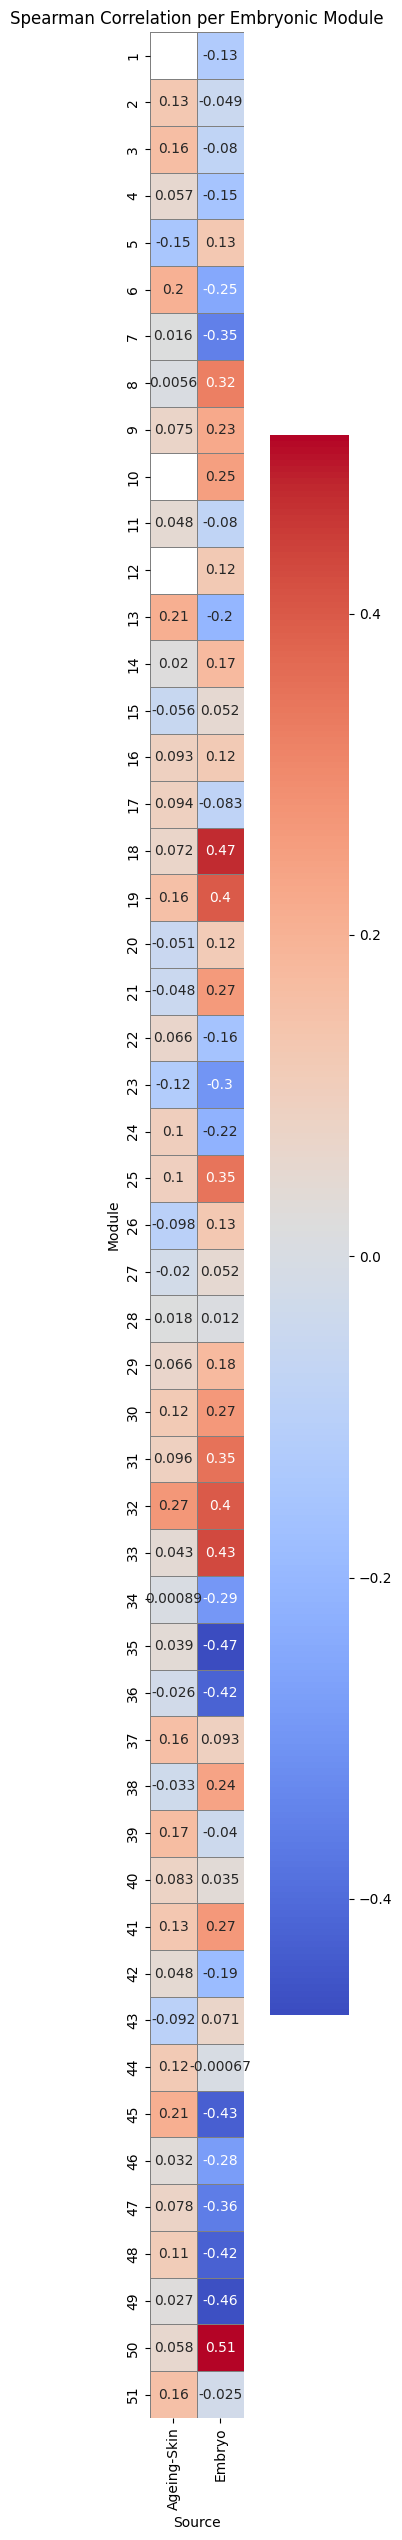

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, len(heatmap_data) * 0.5))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='coolwarm',  # or any other color map
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    square=True
)

plt.title("Spearman Correlation per Embryonic Module")
plt.xlabel("Source")
plt.ylabel("Module")
plt.tight_layout()
plt.show()

! Code further was used to better understand dinamics and content of each module

In [ ]:
mod_genes = module_df[module_df['module'] == 49]
mod_genes_list = mod_genes["ENSEMBL"]
mod_genes_list = mod_genes_list.to_list()
mod_genes_list


['ENSG00000139832',
 'ENSG00000120925',
 'ENSG00000113558',
 'ENSG00000156831',
 'ENSG00000152193',
 'ENSG00000128731',
 'ENSG00000099968',
 'ENSG00000114737',
 'ENSG00000064933',
 'ENSG00000090520',
 'ENSG00000221988',
 'ENSG00000159720',
 'ENSG00000077152',
 'ENSG00000161921',
 'ENSG00000156374',
 'ENSG00000115009',
 'ENSG00000081870',
 'ENSG00000163002',
 'ENSG00000171621',
 'ENSG00000130349',
 'ENSG00000164162',
 'ENSG00000099940',
 'ENSG00000139197']

In [ ]:
mod50_genes_list = mod50_genes_list.reset_index()
mod50_genes_list

,index,ENSEMBL
0,914,ENSG00000257218
1,915,ENSG00000121741
2,916,ENSG00000104881
3,917,ENSG00000136014
4,918,ENSG00000243927
...,...,...
1574,2488,ENSG00000157954
1575,2489,ENSG00000080802
1576,2490,ENSG00000005249
1577,2491,ENSG00000186591


In [ ]:
print(mod50_genes["ENSEMBL"].to_list())

['ENSG00000257218', 'ENSG00000121741', 'ENSG00000104881', 'ENSG00000136014', 'ENSG00000243927', 'ENSG00000120696', 'ENSG00000127870', 'ENSG00000110931', 'ENSG00000157557', 'ENSG00000102805', 'ENSG00000221983', 'ENSG00000105700', 'ENSG00000105701', 'ENSG00000184900', 'ENSG00000105325', 'ENSG00000136100', 'ENSG00000139517', 'ENSG00000139144', 'ENSG00000130255', 'ENSG00000100300', 'ENSG00000134905', 'ENSG00000100083', 'ENSG00000100330', 'ENSG00000134882', 'ENSG00000087088', 'ENSG00000007047', 'ENSG00000099949', 'ENSG00000134285', 'ENSG00000062822', 'ENSG00000065150', 'ENSG00000198300', 'ENSG00000100401', 'ENSG00000167470', 'ENSG00000150907', 'ENSG00000077463', 'ENSG00000105229', 'ENSG00000196072', 'ENSG00000167658', 'ENSG00000182944', 'ENSG00000167657', 'ENSG00000136156', 'ENSG00000204977', 'ENSG00000136167', 'ENSG00000136161', 'ENSG00000125247', 'ENSG00000100219', 'ENSG00000107566', 'ENSG00000196365', 'ENSG00000189306', 'ENSG00000138942', 'ENSG00000148773', 'ENSG00000154719', 'ENSG000001

In [ ]:
df_means = pd.read_csv("/content/module_eigengenes.csv", index_col=0)
meta = metadata_df
df_means["Day"] = meta["day"]

For more detailed visualisation of eigengene trajectories:

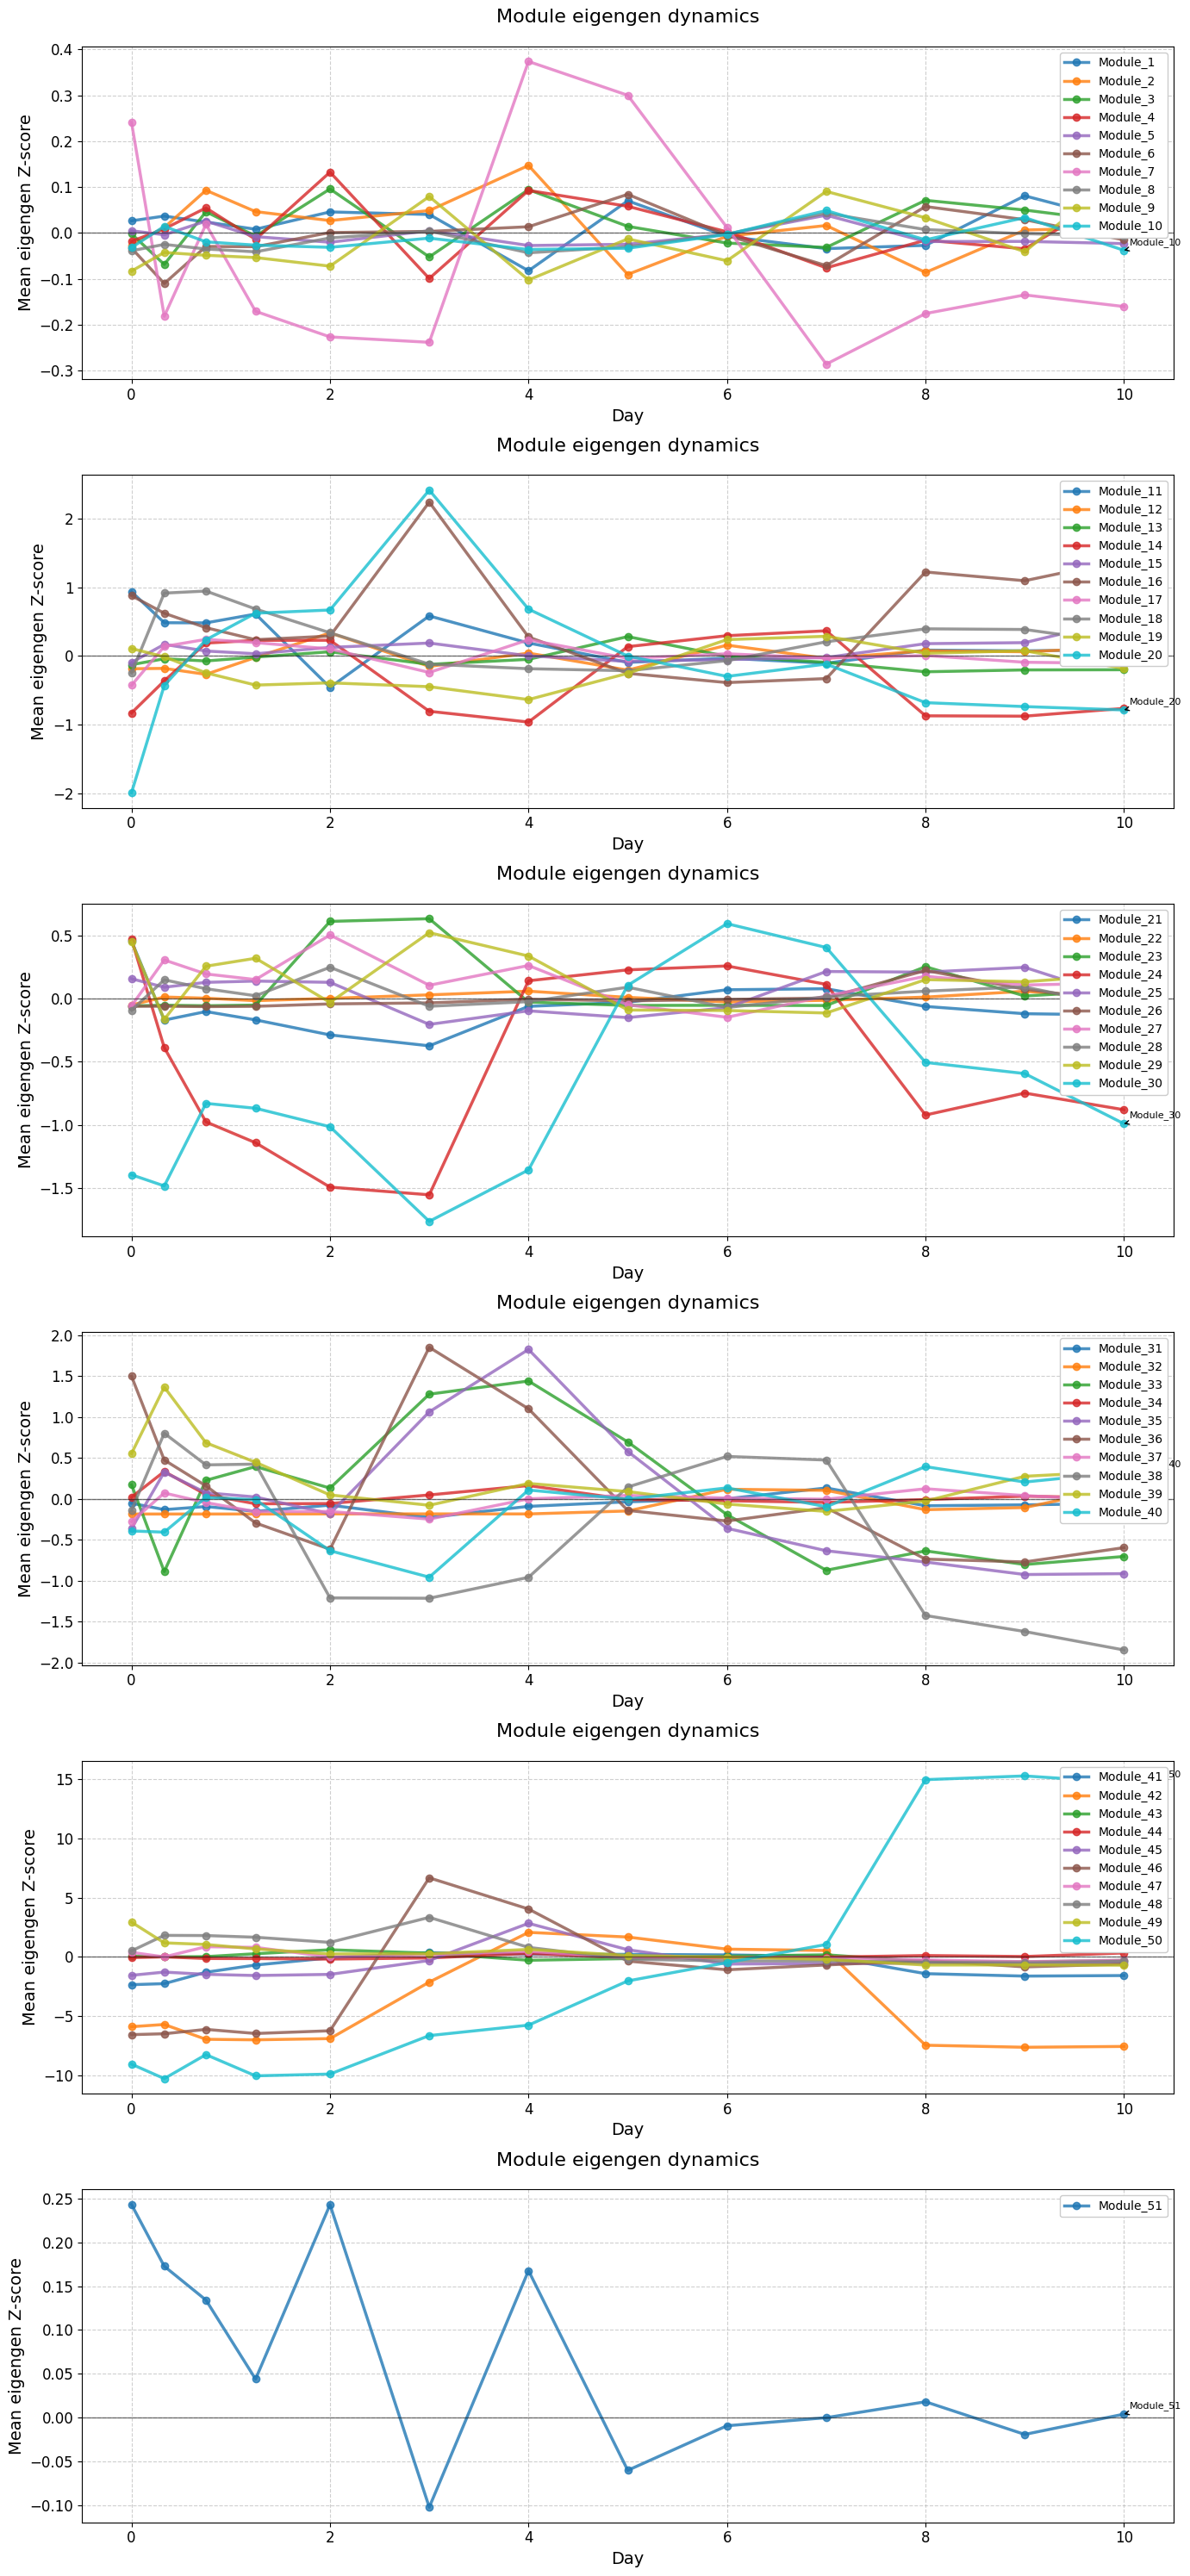

In [ ]:
daily_means = df_means.groupby('Day').mean()

# 10 modules per subplot
num_modules = daily_means.shape[1]
num_subplots = (num_modules // 10) + (num_modules % 10 > 0)


fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 5 * num_subplots))
axs = axs.flatten()


for i, module in enumerate(daily_means.columns):
    subplot_index = i // 10
    axs[subplot_index].plot(daily_means.index,
                            daily_means[module],
                            label=module,
                            linewidth=2.5,
                            alpha=0.8,
                            marker='o',
                            markersize=6)

    # + Annotations
    if (i % 10) == 9 or (i == num_modules - 1):
        y_last = daily_means[module].iloc[-1]
        x_last = daily_means.index[-1]
        axs[subplot_index].annotate(f'{module}',
                                    xy=(x_last, y_last),
                                    xytext=(5, 5),
                                    textcoords='offset points',
                                    fontsize=8,
                                    arrowprops=dict(arrowstyle='->', color='black'))


for ax in axs:
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_title('Module eigengen dynamics', fontsize=16, pad=20)
    ax.set_xlabel('Day', fontsize=14)
    ax.set_ylabel('Module eigengen (mean by day)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=12)


for ax in axs:
    ax.legend(loc='upper right', fontsize=10, framealpha=1)

plt.tight_layout()

plt.show()

day - timepiont

0 - oocyte

0.33 - pronucleus

0.75 - zygote

1.25 - 2C

2 - 4C

3 - E3/8C

4 - E4/Morula

5 - E5

6 - E6

7 - E7

8 - E8

9 - E9

10 - E10

In [ ]:
meta_sorted = meta.sort_values('day')
meta_sorted

,day,ct,experiment,technology,n_counts,n_genes,ct_fine,timepoint
index,,,,,,,,
SRX300875_SRX300875,0.0,Oocyte,Xue_2013,Tang2009,9053667.0,11428,Prelineage,Oocyte
SRX300873_SRX300873,0.0,Oocyte,Xue_2013,Tang2009,11823220.0,9397,Prelineage,Oocyte
SRX129997_SRX129997,0.0,Oocyte,Yan_2013,SMARTSeq,22764546.0,20802,Prelineage,Oocyte
SRX129998_SRX129998,0.0,Oocyte,Yan_2013,SMARTSeq,21446276.0,20847,Prelineage,Oocyte
SRX129999_SRX129999,0.0,Oocyte,Yan_2013,SMARTSeq,17770880.0,21136,Prelineage,Oocyte
...,...,...,...,...,...,...,...,...
SRX6774952_SRX6774952,10.0,Primitive Endoderm,Xiang_2020,SMARTSeq2,10566620.0,12808,Primitive Endoderm,E10.0
SRX6774951_SRX6774951,10.0,Trophectoderm,Xiang_2020,SMARTSeq2,11641322.0,11887,Trophectoderm_10.0,E10.0
SRX6774953_SRX6774953,10.0,Trophectoderm,Xiang_2020,SMARTSeq2,8212720.0,10512,Trophectoderm_10.0,E10.0


In [ ]:
meta_sorted["timepoint"].unique()

array(['Oocyte', 'Pronucleus', 'Zygote', '2C', '4C', '8C', 'E3.0',
       'Morula', 'E4.0', 'E5.0', 'E6.0', 'E7.0', 'E8.0', 'E9.0', 'E10.0'],
      dtype=object)